In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import numpy as np
import matplotlib.pyplot as plt

# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Mount Google Drive

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/DataSets/'
# Define the path to your dataset directory

# Define the batch size
batch_size = 32

# Create a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + 'Training/',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(32, 32),
    shuffle=True,
    seed=123
)

# Create a test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + 'Testing/',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(32, 32),
    shuffle=False
)

Found 2600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


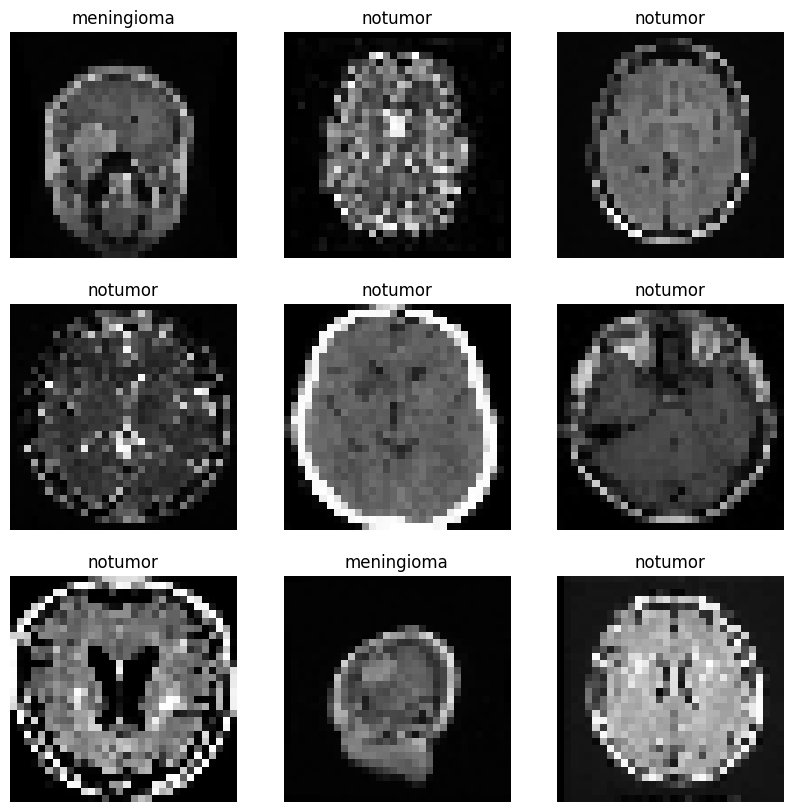

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Define the ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', name=name + '_1_conv')(x)
    x = layers.BatchNormalization(name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = layers.BatchNormalization(name=name + '_2_bn')(x)

    x = layers.add([shortcut, x], name=name + '_add')
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

# Define the ResNet model
def resnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', name='conv1_conv')(inputs)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same', name='pool1_pool')(x)

    x = resnet_block(x, 64, conv_shortcut=False, name='conv2_block1')
    x = resnet_block(x, 64, name='conv2_block2')
    x = layers.Dropout(0.3)(x)  # Add dropout for regularization

    x = resnet_block(x, 128, stride=2, name='conv3_block1')  # Increase filters and add stride for downsampling
    x = resnet_block(x, 128, name='conv3_block2')
    x = layers.Dropout(0.3)(x)  # Add dropout for regularization

    x = resnet_block(x, 256, stride=2, name='conv4_block1')  # Increase filters and add stride for downsampling
    x = resnet_block(x, 256, name='conv4_block2')
    x = layers.Dropout(0.3)(x)  # Add dropout for regularization

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs, outputs, name='resnet')
    return model

    # Define the input shape
input_shape = (32, 32, 3)  # Adjust according to your image size

# Define the number of classes
num_classes = 2  # meningioma and no tumor


# Create an instance of the ResNet model
model = resnet(input_shape, num_classes)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Adjust learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                              
                                                                                                  
 conv1_relu (Activation)     (None, 16, 16, 64)           0         ['conv1_bn[0][0]']       

In [ ]:
# Define the number of epochs
epochs = 10

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

# Plot training and validation accuracy
import matplotlib.pyplot as plt

Epoch 1/10
82/82 [==============================] - 730s 9s/step - loss: 0.4756 - accuracy: 0.7835 - val_loss: 0.5837 - val_accuracy: 0.6783
Epoch 2/10
82/82 [==============================] - 10s 115ms/step - loss: 0.2869 - accuracy: 0.8977 - val_loss: 0.3830 - val_accuracy: 0.8267
Epoch 3/10
82/82 [==============================] - 10s 119ms/step - loss: 0.2255 - accuracy: 0.9073 - val_loss: 0.2424 - val_accuracy: 0.8950
Epoch 4/10
82/82 [==============================] - 9s 102ms/step - loss: 0.1694 - accuracy: 0.9358 - val_loss: 0.1720 - val_accuracy: 0.9283
Epoch 5/10
82/82 [==============================] - 10s 114ms/step - loss: 0.1534 - accuracy: 0.9392 - val_loss: 0.1543 - val_accuracy: 0.9317
Epoch 6/10
82/82 [==============================] - 10s 116ms/step - loss: 0.1014 - accuracy: 0.9596 - val_loss: 0.0894 - val_accuracy: 0.9633
Epoch 7/10
82/82 [==============================] - 10s 116ms/step - loss: 0.0791 - accuracy: 0.9719 - val_loss: 0.1429 - val_accuracy: 0.9533
Ep

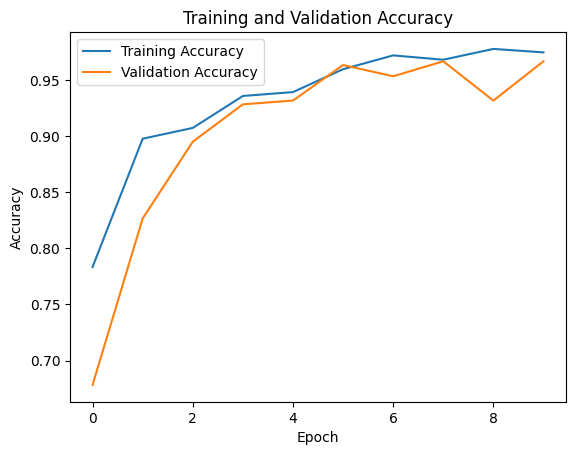

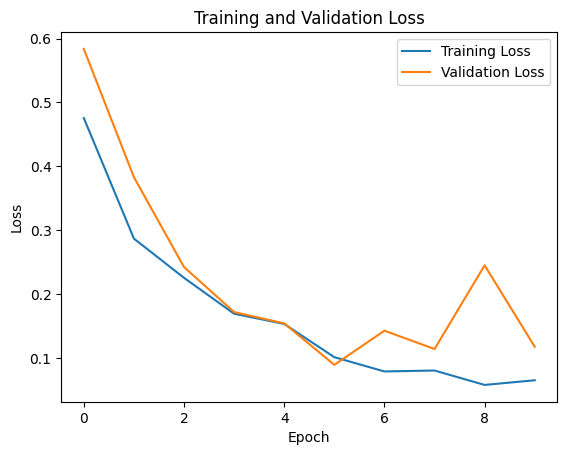

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Define VGG16 model
def vgg16(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define DenseNet model
def densenet(input_shape, num_classes):
    base_model = keras.applications.DenseNet121(weights=None, include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=predictions)
    return model


In [ ]:
# Compile the models using legacy optimizer
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
vgg_model.compile(optimizer=optimizer_legacy, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
densenet_model.compile(optimizer=optimizer_legacy, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the models
epochs = 10
vgg_history = vgg_model.fit(train_ds, validation_data=test_ds, epochs=epochs)
densenet_history = densenet_model.fit(train_ds, validation_data=test_ds, epochs=epochs)


Epoch 1/10
82/82 [==============================] - 14s 140ms/step - loss: 0.0423 - accuracy: 0.9915 - val_loss: 0.0813 - val_accuracy: 0.9717
Epoch 2/10
82/82 [==============================] - 10s 115ms/step - loss: 0.0135 - accuracy: 0.9950 - val_loss: 0.1404 - val_accuracy: 0.9750
Epoch 3/10
82/82 [==============================] - 11s 129ms/step - loss: 0.0204 - accuracy: 0.9912 - val_loss: 0.1314 - val_accuracy: 0.9533
Epoch 4/10
82/82 [==============================] - 12s 141ms/step - loss: 0.0389 - accuracy: 0.9873 - val_loss: 0.2451 - val_accuracy: 0.9133
Epoch 5/10
82/82 [==============================] - 11s 131ms/step - loss: 0.0585 - accuracy: 0.9796 - val_loss: 0.2371 - val_accuracy: 0.9500
Epoch 6/10
82/82 [==============================] - 10s 112ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 0.1151 - val_accuracy: 0.9833
Epoch 7/10
82/82 [==============================] - 10s 111ms/step - loss: 0.0125 - accuracy: 0.9981 - val_loss: 0.0740 - val_accuracy: 0.9883

In [ ]:
# Evaluate the models
resnet_eval = model.evaluate(test_ds)
vgg_eval = vgg_model.evaluate(test_ds)
densenet_eval = densenet_model.evaluate(test_ds)

# Display results in a table
import pandas as pd

data = {
    'Model': ['ResNet', 'VGG16', 'DenseNet'],
    'Test Loss': [resnet_eval[0] *100, vgg_eval[0] *100, densenet_eval[0] *100],
    'Test Accuracy': [resnet_eval[1] *100, vgg_eval[1] *100, densenet_eval[1]*100]
}

results_df = pd.DataFrame(data)
print(results_df)


19/19 [==============================] - 2s 87ms/step - loss: 0.1065 - accuracy: 0.9717
      Model  Test Loss  Test Accuracy
0    ResNet  11.773656      96.666664
1     VGG16  14.340162      97.333336
2  DenseNet  10.645084      97.166669
